In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function, absolute_import

import copy
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import torch
from torch.nn.init import *

from multiple_traj_opt import *
from nn_system.networks import *
from traj.vi_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
##### RUSS'S MINIBATCH METHOD
seed = 1776; np.random.seed(seed); torch.manual_seed(seed)

use_dropout = True
nn_init     = kaiming_uniform_ # Will this even do anything with warm starting?
nn_noise    = 1e-2
class FCBIG(nn.Module):
    def __init__(self, n_inputs=4, h_sz=32, nn_init=None, nn_noise=0., use_dropout=False):
        self.nn_noise = nn_noise
        self.use_dropout = use_dropout
        super(FCBIG, self).__init__()
        self.n_inputs = n_inputs
        self.fc1 = nn.Linear(self.n_inputs, h_sz)
        self.fc2 = nn.Linear(h_sz, 1)
        
        if use_dropout:
            self.dropout = nn.Dropout(0.5) 
        
        if nn_init is not None:
            nn_init(self.fc1.weight)
            nn_init(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        x += self.nn_noise # Will this work in Torch?
        return x
    

# new_mto = None
# N = 1
N = multiprocessing.cpu_count() - 2
new_mtos = [None]*N

total_iterations = 10

vi_policy, _ = load_policy("good", "pendulum")

########################################
# MACHINERY FOR PARALLELISM

def do_serial(method, mto, ic_list, **kwargs):
    print("{} doing serial method".format(kwargs["i"]))
    old_mto, new_mto = method(mto, ic_list, **kwargs)
    print("{} FINISHED serial method".format(kwargs["i"]))
    if old_mto is not None:
        old_mto.nn_cons = []
        old_mto.nn_costs = []
        old_mto.prog = None
        old_mto.h = None
        old_mto.u = None
        old_mto.x = None
        old_mto.T = None
    if new_mto is not None:
        new_mto.nn_cons = []
        new_mto.nn_costs = []
        new_mto.prog = None
        new_mto.h = None
        new_mto.u = None
        new_mto.x = None
        new_mto.T = None
    return old_mto, new_mto
#     return copy.deepcopy(old_mto), copy.deepcopy(new_mto)
def parallel_helper(inp):
    (method, mto, ic_list, kwargs) = inp
    return do_serial(method, mto, ic_list, **kwargs)
def do_parallel(method, mtos, ic_lists, **kwargs):
    from pathos.multiprocessing import ProcessingPool as Pool
    p = Pool(1)
    inputs = []
    for i, (mto, ic_list) in enumerate(zip(mtos, ic_lists)):
        kwargs_copy = copy.deepcopy(kwargs)
        kwargs_copy['i'] = i
        if i != 0: # Disable all but the first visualization stream when running parallel
            kwargs_copy["vis_cb_every_nth"] = None
            kwargs_copy["cost_cb_every_nth"] = None
#         mto.nn_cons = []
#         mto.nn_costs = []
#         if mto is not None:
#             mto.prog = None
        inputs.append((method, mto, ic_list, kwargs_copy))
    results = p.map(parallel_helper, inputs)
    old_mtos, new_mtos = zip(*results)
    return 

def kNetConstructor():
    return FCBIG(n_inputs=2, nn_init=nn_init)

while total_iterations > 0:
    total_iterations -= 1
    num_trajectories = 7
    ic_list = initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5, 5))
#     old_mto, new_mto = do_serial(method4,
#                                  new_mto, 
    old_mtos, new_mtos = do_parallel(method4,
                                 new_mtos, 
                              [ic_list, ic_list], 
                              num_trajectories=num_trajectories,
                              expmt = "pendulum",
                              kNetConstructor=kNetConstructor,
                              use_constraint=False,
                              cost_factor=25.,
                              vis_cb_every_nth=50, 
                              cost_cb_every_nth=50, 
                              seed=None,
                              snopt_overrides=[('Time limit (secs)',  6.0)])
    # Print learned policy vs vi_policy here (only possible for state dim == 2)
    net = new_mto.create_net()
    net.eval()
    if new_mto.expmt == "pendulum":
        vis_vi_policy(vi_policy)
        vis_nn_policy_like_vi_policy(net, vi_policy)

    # Print Divergence metrics between the two policies
    results = []
    if new_mto.expmt == "pendulum":
        test_coords = initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5/2, 5/2))
    elif new_mto.expmt == "cartpole":
        test_coords = initial_conditions_random_all_dims(num_trajectories, ((-3., 3.), (0., 2*math.pi), (-1., 1.), (-1., 1.)) )
    test_coords = ic_list
    for coord in test_coords:
        pair = (eval_vi_policy(coord, vi_policy), eval_nn_policy(coord, net))
        results.append(pair)
    diffs = [result[1] - result[0] for result in results]
    plot_and_print_statistics(diffs, "nn - vi policy deviations", bins=100, xlim=None)
        
        

0 doing serial method
do parallel with inputs =  [(<function method4 at 0x7fc6f33b9cf8>, None, [(0.8958035420343874, 0.03690487452916713), (1.4774518249815176, 1.3189538052113035), (1.078874778668297, -4.834045615747992), (1.0476357041004332, -0.38643700024604133), (5.945095271636019, 3.8882622147306183), (2.3636644912001654, -4.841389765824612), (6.044825506365275, 1.1229440347725719)], {'snopt_overrides': [('Time limit (secs)', 6.0)], 'expmt': 'pendulum', 'i': 0, 'vis_cb_every_nth': 50, 'kNetConstructor': <function kNetConstructor at 0x7fc6e74d9938>, 'seed': None, 'cost_cb_every_nth': 50, 'cost_factor': 25.0, 'use_constraint': False, 'num_trajectories': 7}), (<function method4 at 0x7fc6f33b9cf8>, None, [(0.8958035420343874, 0.03690487452916713), (1.4774518249815176, 1.3189538052113035), (1.078874778668297, -4.834045615747992), (1.0476357041004332, -0.38643700024604133), (5.945095271636019, 3.8882622147306183), (2.3636644912001654, -4.841389765824612), (6.044825506365275, 1.1229440347

## ----------------------------------------- Visualizations below this line --------------------------------------

In [ ]:
#### Get a sense of the consistency of x and u!
# Let's plot all the u's on the z axis and x (theta, theta_dot) on the y and x axes...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [], [], []
for ti in range(new_mto.num_trajectories):
    h_sol  = new_mto.prog.GetSolution(new_mto.h[ti])[0]
    print(h_sol)

    t_s = [h_sol*i for i in range(new_mto.num_samples)]
    x_s  = new_mto.prog.GetSolution(new_mto.x[ti])
    u_s    = new_mto.prog.GetSolution(new_mto.u[ti])
    x_trajectory = PiecewisePolynomial.Cubic(t_s, x_s, False)
#     t_samples = np.linspace(breaks[0], breaks[-1], 100) 
#     x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])
    thetas, theta_dots = zip(*x_s)
    print(thetas, theta_dots, u_s)
    xs += thetas
    ys += theta_dots
    zs += u_s
print(list((len(thing) for thing in (xs, ys, zs))))
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


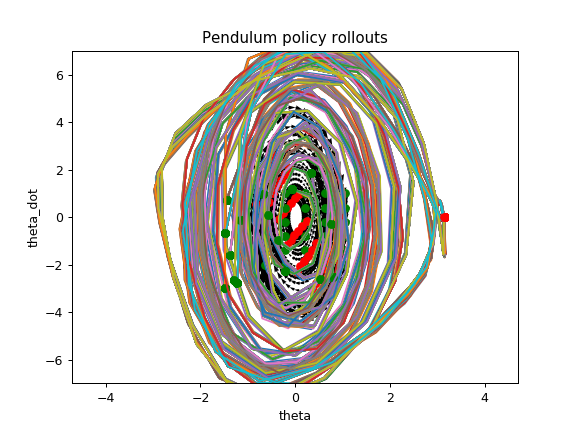

In [28]:
import math
ic_list = initial_conditions_grid(36, (-math.pi/3, math.pi/3), (-5/3, 5/3))
new_mto.plot_all_policies("state_quiver", ic_list)

In [ ]:
from nn_system.NNSystemHelper import create_nn
kNetConstructor = lambda: FCBIG(2)
nn = create_nn(kNetConstructor, list(new_mto.prog.GetSolution(new_mto.T)))
list(nn.parameters())

In [ ]:
ti = 0
mto.render_policy(ti)

<IPython.core.display.Javascript object>


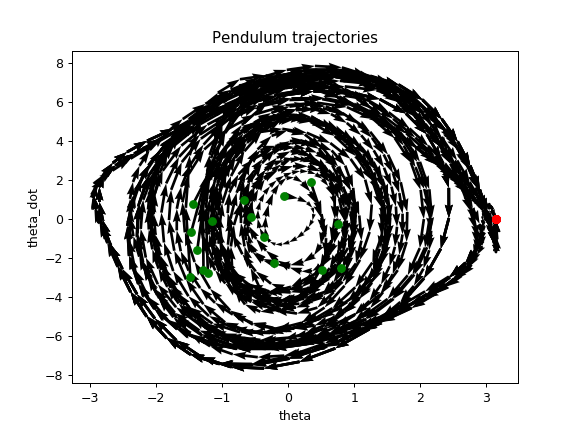

In [27]:
# mto.plot_all_trajectories("state_scatter")
new_mto.plot_all_trajectories("state_quiver")
# mto.plot_all_trajectories("tip_scatter")
# mto.plot_all_trajectories("tip_quiver")

### Visualize the found trajectories

In [ ]:
ti = 0
mto.plot_single_trajectory(ti, "state_scatter")
mto.plot_single_trajectory(ti, "state_quiver")
mto.plot_single_trajectory(ti, "tip_scatter")
mto.plot_single_trajectory(ti, "tip_quiver")

mto.render_single_trajectory(ti)